In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast
import re
import ast
import numpy as np
from matplotlib.patches import Patch

ANALYSIS_FOLDER = 'Experiments_Folder/VizRec/Analysis/'

In [22]:
def get_user_name(url):

    if len(url) >15 or url.endswith('.csv'):
        parts = url.split('/')
        fname = parts[-1]
        uname = fname.rstrip('_log.csv')
        return uname
    return url

In [16]:
def rename_algorithms(df):
           #trim everything before first - for the algorithm name
        df['Algorithm'] = df['Algorithm'].apply(lambda x: x.split('-')[0])
        #rename algorithm name if AC then change to Actor-Critic if Online change to Online SVM if FullOffline change to  Offline SVM
        df['Algorithm'] = df['Algorithm'].apply(lambda x: 'ActorCritic' if x == 'AC' else x)
        df['Algorithm'] = df['Algorithm'].apply(lambda x: 'Online SVM' if x == 'Online' else x)
        #df['Algorithm'] = df['Algorithm'].apply(lambda x: 'Offline SVM' if x == 'FullOfflineSVM' else x)
        return df


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import ast

# Function to map predictions and ground truth to encoded values
def encode_predictions(user_data, prediction_map):
    """
    Encode the predictions and ground truth based on a mapping and return a dictionary
    of algorithms with their corresponding encoded predictions.

    Parameters:
    - user_data: DataFrame containing user-specific results (including predictions).
    - prediction_map: Dictionary mapping prediction categories to integers.

    Returns:
    - algorithm_pred: Dictionary with algorithms as keys and encoded prediction lists as values.
    """
    algorithm_pred = {}

    # Find QLearn's encoded truth, assume QLearn exists in the dataset
    qlearn_data = user_data[user_data['Algorithm'] == 'QLearn']
    if not qlearn_data.empty:
        qlearn_truth = [prediction_map[truth] for truth in ast.literal_eval(qlearn_data.iloc[0]['GroundTruth'])]
        algorithm_pred['Truth'] = qlearn_truth

    # Encode predictions for all algorithms
    for index, row in user_data.iterrows():
        encode_pred = [prediction_map[pred] for pred in ast.literal_eval(row['Predictions'])]
        algorithm_pred[row['Algorithm']] = encode_pred

    return algorithm_pred

# Function to normalize the length of all prediction lists
def normalize_prediction_lengths(algorithm_pred):
    """
    Ensure all prediction lists in the dictionary have the same length by padding
    shorter lists with 0.

    Parameters:
    - algorithm_pred: Dictionary with algorithms and their corresponding encoded predictions.

    Returns:
    - algorithm_pred: Dictionary with predictions lists of the same length.
    """
    #get min length
    min_length = min([len(algorithm_pred[algorithm]) for algorithm in algorithm_pred])
    #subtract min length from all lists
    for algorithm in algorithm_pred:
        algorithm_pred[algorithm] = algorithm_pred[algorithm][:min_length]
    return algorithm_pred

# Function to plot the heatmap with categorical color index
def plot_encoded_predictions_heatmap(pred_df, user, categories, category_colors):
    """
    Plot a heatmap of encoded predictions with a categorical color index.

    Parameters:
    - pred_df: DataFrame containing the encoded predictions for each algorithm.
    - user: User identifier for the title of the plot.
    - categories: Unique categories used for encoding predictions.
    - category_colors: List of colors corresponding to the categories.
    """
    sns.set(style='whitegrid')
    plt.figure(figsize=(12, 6))

    # Create a heatmap with space between algorithms
    ax = sns.heatmap(pred_df.T, cmap=category_colors, cbar=False, annot=False, fmt='d',
                     linewidths=2, linecolor='white')

    # Add title and labels
    plt.title(f'Encoded Predictions for User {user}')
    ax.set_xticks([])  # Remove x labels and ticks
    plt.ylabel('Algorithm')

    # Create patches for the categorical color legend
    legend_patches = [Patch(color=category_colors[i], label=f'modify-{categories[i]}')
                      for i in range(len(categories))]

    # Add a legend to the right of the plot
    plt.legend(handles=legend_patches, title="Data Focus Shifts", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Display the plot
    plt.tight_layout()
    plt.show()

# Driver function to process and visualize user prediction data
def driver_function(combined_results, user, prediction_map):
    """
    Orchestrates the encoding, normalization, and plotting of predictions for a given user.

    Parameters:
    - combined_results: DataFrame containing all user results.
    - user: Specific user identifier to filter the data.
    - prediction_map: Dictionary mapping prediction categories to integers.
    """
    # Filter user-specific data
    user_data = combined_results[combined_results['User'] == user]

    # Step 1: Encode predictions and ground truth (using QLearn's truth for all algorithms)
    algorithm_pred = encode_predictions(user_data, prediction_map)

    # Step 2: Normalize prediction lengths
    algorithm_pred = normalize_prediction_lengths(algorithm_pred)

    # Step 3: Add accuracy to the algorithm names
    user_data['AlgorithmWithAccuracy'] = user_data.apply(lambda row: f"{row['Algorithm']} ({row['Accuracy']:.2%})", axis=1)

    # Update algorithm_pred to use names with accuracies
    algorithm_pred_with_acc = {}
    for algorithm in algorithm_pred:
        if algorithm == 'Truth':
            algorithm_pred_with_acc['Truth'] = algorithm_pred[algorithm]
            #create new algorithm called ShiftTruth where you shift the truth by 1 right last is 0
            algorithm_pred_with_acc['ShiftTruth'] = [0] + algorithm_pred['Truth'][:-1]
        else:
            accuracy = user_data[user_data['Algorithm'] == algorithm]['Accuracy'].values[0]
            algorithm_with_acc = f"{algorithm} ({accuracy:.2%})"
            algorithm_pred_with_acc[algorithm_with_acc] = algorithm_pred[algorithm]

    # Step 4: Create a DataFrame for the encoded predictions
    pred_df = pd.DataFrame(algorithm_pred_with_acc)

    # Step 5: Generate distinct colors for the categories
    categories = np.unique(pred_df.values)

    category_colors = sns.color_palette("tab10", len(categories))

    # Step 6: Plot the encoded predictions heatmap
    plot_encoded_predictions_heatmap(pred_df, user, categories, category_colors)

# Example usage:
# driver_function(combined_results, user, prediction_map)


In [27]:
datasets = ['movies', 'birdstrikes']
tasks = ['p1', 'p2', 'p3', 'p4']
algorithms = ['QLearn-Aligned-Test-Single-Model', 'QLearn-Single-Model', 'FullOfflineSVM-Single-Model', 'Online-SVM-Single-Model']

combined_results = pd.DataFrame()
for dataset in datasets:
    for task in tasks:
        for algorithm in algorithms:
            #combine into the same dataframe
            print(f'Experiments_Folder/VizRec/{dataset}/{task}/{algorithm}.csv')
            file_name = f"Experiments_Folder/VizRec/{dataset}/{task}/{algorithm}.csv"

            results = pd.read_csv(file_name)
            results['Dataset'] = dataset
            results['Task'] = task
            results['Algorithm'] = algorithm
            if algorithm =="QLearn-Aligned-Test-Single-Model":
                results['Algorithm'] = "QLearnAligned"
            if algorithm =="FullOfflineSVM-Single-Model":
                results['Algorithm'] = "Offline SVM"
            combined_results = pd.concat([combined_results, results])

Experiments_Folder/VizRec/movies/p1/QLearn-Aligned-Test-Single-Model.csv
Experiments_Folder/VizRec/movies/p1/QLearn-Single-Model.csv
Experiments_Folder/VizRec/movies/p1/FullOfflineSVM-Single-Model.csv
Experiments_Folder/VizRec/movies/p1/Online-SVM-Single-Model.csv
Experiments_Folder/VizRec/movies/p2/QLearn-Aligned-Test-Single-Model.csv
Experiments_Folder/VizRec/movies/p2/QLearn-Single-Model.csv
Experiments_Folder/VizRec/movies/p2/FullOfflineSVM-Single-Model.csv
Experiments_Folder/VizRec/movies/p2/Online-SVM-Single-Model.csv
Experiments_Folder/VizRec/movies/p3/QLearn-Aligned-Test-Single-Model.csv
Experiments_Folder/VizRec/movies/p3/QLearn-Single-Model.csv
Experiments_Folder/VizRec/movies/p3/FullOfflineSVM-Single-Model.csv
Experiments_Folder/VizRec/movies/p3/Online-SVM-Single-Model.csv
Experiments_Folder/VizRec/movies/p4/QLearn-Aligned-Test-Single-Model.csv
Experiments_Folder/VizRec/movies/p4/QLearn-Single-Model.csv
Experiments_Folder/VizRec/movies/p4/FullOfflineSVM-Single-Model.csv
Expe

In [28]:
individual_algorithms=['QLearn-Individual-Model', 'QLearnAligned-Individual-Model']

#(f"Experiments_Folder/VizRec/{dataset}/{task}/Individual/QLearn-Individual-Model.csv")

for dataset in datasets:
    for task in tasks:
        for algorithm in individual_algorithms:
            #combine into the same dataframe
            print(f'Experiments_Folder/VizRec/{dataset}/{task}/Individual/{algorithm}.csv')
            file_name = f"Experiments_Folder/VizRec/{dataset}/{task}/Individual/{algorithm}.csv"

            results = pd.read_csv(file_name)
            results['Dataset'] = dataset
            results['Task'] = task
            results['Algorithm'] = algorithm
            combined_results = pd.concat([combined_results, results])

Experiments_Folder/VizRec/movies/p1/Individual/QLearn-Individual-Model.csv
Experiments_Folder/VizRec/movies/p1/Individual/QLearnAligned-Individual-Model.csv
Experiments_Folder/VizRec/movies/p2/Individual/QLearn-Individual-Model.csv
Experiments_Folder/VizRec/movies/p2/Individual/QLearnAligned-Individual-Model.csv
Experiments_Folder/VizRec/movies/p3/Individual/QLearn-Individual-Model.csv
Experiments_Folder/VizRec/movies/p3/Individual/QLearnAligned-Individual-Model.csv
Experiments_Folder/VizRec/movies/p4/Individual/QLearn-Individual-Model.csv
Experiments_Folder/VizRec/movies/p4/Individual/QLearnAligned-Individual-Model.csv
Experiments_Folder/VizRec/birdstrikes/p1/Individual/QLearn-Individual-Model.csv
Experiments_Folder/VizRec/birdstrikes/p1/Individual/QLearnAligned-Individual-Model.csv
Experiments_Folder/VizRec/birdstrikes/p2/Individual/QLearn-Individual-Model.csv
Experiments_Folder/VizRec/birdstrikes/p2/Individual/QLearnAligned-Individual-Model.csv
Experiments_Folder/VizRec/birdstrikes/

In [30]:
#all algorithms
#list
algorithms = combined_results['Algorithm'].unique()
algorithms

array(['QLearnAligned', 'QLearn-Single-Model', 'Offline SVM',
       'Online-SVM-Single-Model', 'QLearn-Individual-Model',
       'QLearnAligned-Individual-Model'], dtype=object)

All algorithms for user pro14_bdf_p3: ['QLearnAligned' 'QLearn-Single-Model' 'QLearn-Individual-Model'
 'QLearnAligned-Individual-Model']


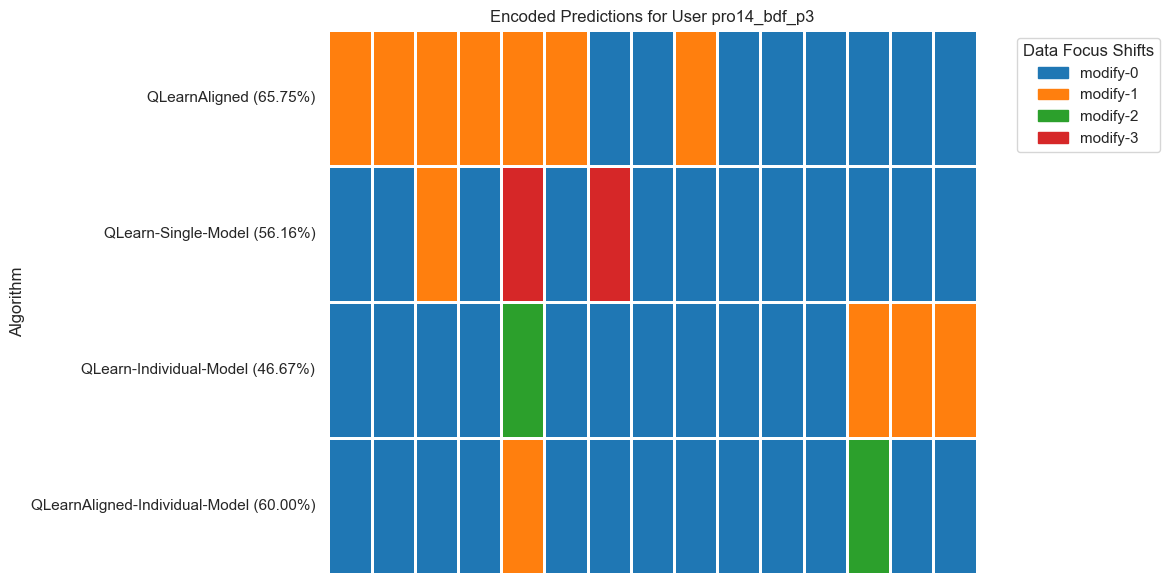

In [33]:
user = 'pro14_bdf_p3'
resulting=combined_results[combined_results['User'] == user]
print(f'All algorithms for user {user}: {resulting["Algorithm"].unique()}')
prediction_map = {'same': 0, 'modify-1': 1, 'modify-2': 2, 'modify-3': 3}
# Call the driver function with the necessary parameters
driver_function(resulting, user, prediction_map)